In [11]:
import os
import subprocess

import matplotlib.pyplot as plt
import torch

CUDA = "1"

In [13]:
for num_bases in (140,):
    for num_sessions in (25,):
        # Run the generation script
        cmd = [
            "python", "tma_standalone.py",
            str(num_bases),
            str(num_sessions),
            CUDA,
        ]
        
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1
        )
        
        # Stream output line by line
        for line in process.stdout:
            print(line, end='')       # print without adding extra newline
            sys.stdout.flush()        # ensure it shows immediately in Jupyter
        
        process.wait()  # wait for completion

----------- Device: 1, out: test/140_25 ------------
Batch shapes:
Train
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
Test
torch.Size([1250, 20, 93])
torch.Size([1250, 20, 93])
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 0.6647977828979492 1.08795565366745 -0.04713331901002675 0.033143386244773865
---- 1000 0.3950238823890686 0.7119979560375214 0.3793571001291275 0.38972485065460205
---- 2000 0.388063907623291 0.7087129354476929 0.3904020571708679 0.39218510687351227
---- 3000 0.37439829111099243 0.6839508414268494 0.4115425437688828 0.41308437287807465
---- 4000 0.371182918548584 0.680832028388977 0.4166910237073898 0.416509747505188
---- 5000 0.36771589517593384 0.681151270866394 0.42156041264533994 0.4163857698440552
---- 6000 0.3649778962135315 0.6741706132888794 0.4260986536741257 0.42217136919498444
---- 7000 0.3660404086112976 0.6756055653095245 0.4244

In [ ]:
# Summarize results
subdirs = os.listdir("test")

tr2s = {}
snum_bases = set()
snum_sessions = set()
for sd in subdirs:
    rpath = os.path.join("test", sd, "r_nf_1.torch")
    res = torch.load(rpath, map_location="cpu")

    try:
        num_bases, num_sessions = [int(tok) for tok in sd.split("_")]
    except ValueError:
        continue

    snum_bases.add(num_bases)
    snum_sessions.add(num_sessions)

    _tr2s = res["final_test_r2s"]
    for sid, tr2 in _tr2s.items():
        sres = (tr2, num_bases, num_sessions)
        v = tr2s.setdefault(sid, [])
        v.append(sres)

for _t in tr2s.values():
    _t.sort()

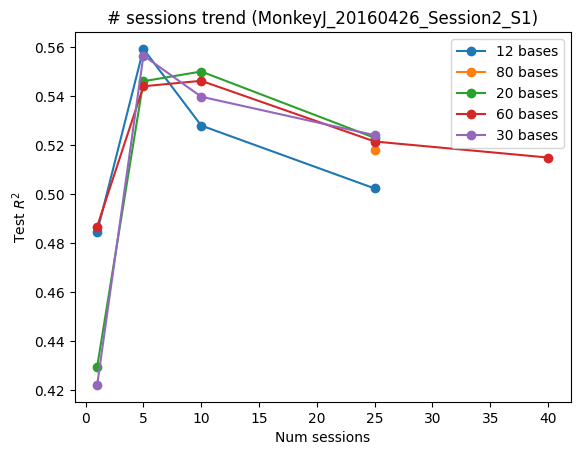

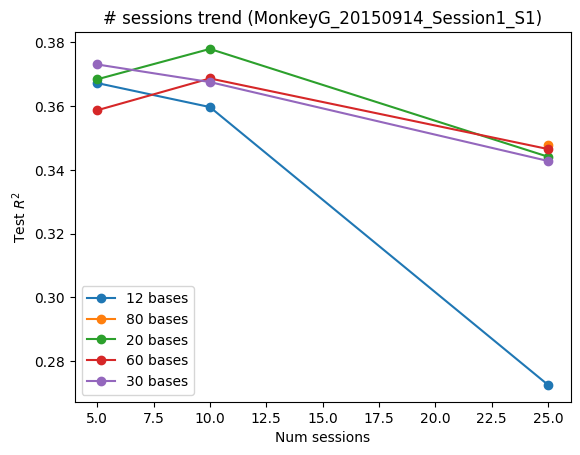

In [4]:
def graph_num_sessions(sid, extras=[]):
    num_sessions_trends = {n: [] for n in snum_bases}
    for _tr2 in tr2s[sid]:
        tr2, num_bases, num_sessions = _tr2
        num_sessions_trends[num_bases].append((num_sessions, tr2))
        
    for extra in extras:
        ebases, esessions, tr2 = extra
        num_sessions_trends[ebases].append((esessions, tr2))
        
    for v in num_sessions_trends.values():
        v.sort()


    for num_bases, v in num_sessions_trends.items():
        try:
            x, y = zip(*v)
        except ValueError:
            continue

        plt.plot(x, y, "o-", label=f"{num_bases} bases")
    plt.legend()
    plt.title(f"# sessions trend ({sid})")
    plt.xlabel(f"Num sessions")
    plt.ylabel("Test $R^2$")
    plt.show()

# From all_session model run:
extras = [(60, 40, 0.514821745455265)]
graph_num_sessions("MonkeyJ_20160426_Session2_S1", extras=extras)
graph_num_sessions("MonkeyG_20150914_Session1_S1")

# Saved model model_as_1.torch
all_sessions_top_tr2 = 0.3817160129547119
tr2_60_25_rr0 = 0.4373730155825615
tr2_60_25_rr32 = 0.438915491104126  # peaked at 0.44194984436035156, probably under-trained
tr2_60_25_rr48 = 0.4407852441072464

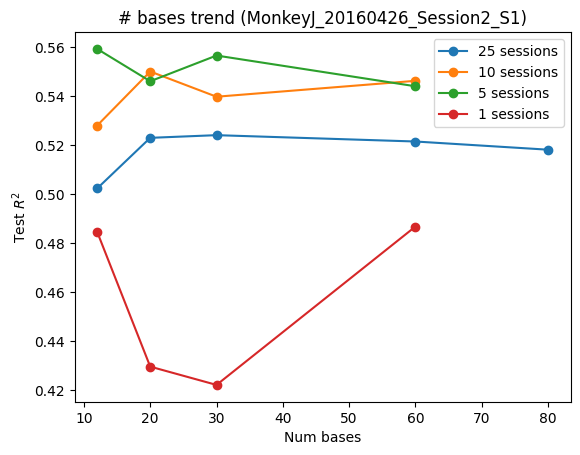

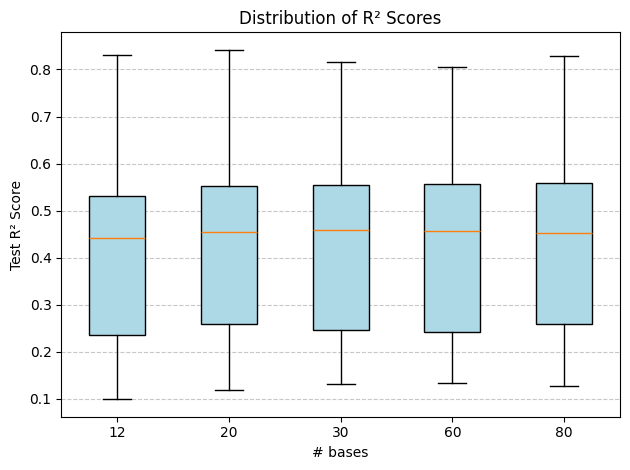

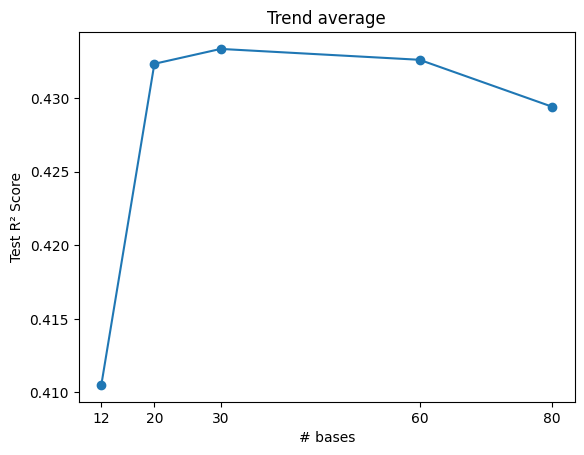

In [5]:
# Let's trend basis count now. Seems like mixed results...
def graph_num_bases(sid):
    num_bases_trends = {n: [] for n in snum_sessions}
    for _tr2 in tr2s[sid]:
        tr2, num_bases, num_sessions = _tr2
        num_bases_trends[num_sessions].append((num_bases, tr2))
    
    for v in num_bases_trends.values():
        v.sort()
    
    for num_sessions, v in num_bases_trends.items():
        try:
            x, y = zip(*v)
        except ValueError:
            continue
        plt.plot(x, y, "o-", label=f"{num_sessions} sessions")
    plt.legend()
    plt.title(f"# bases trend ({sid})")
    plt.xlabel(f"Num bases")
    plt.ylabel("Test $R^2$")
    plt.show()

    target_num_sessions = 25   # Let's see the trend averaged for all sessions
    num_bases_trend = {}   # {num_bases: tr2_sum}
    for sid, trends in tr2s.items():
        for v in trends:
            tr2, num_bases, num_sessions = v
            if num_sessions != target_num_sessions:
                continue
            l = num_bases_trend.setdefault(num_bases, [])
            l.append(tr2)

    a = [(num_bases, l) for num_bases, l in num_bases_trend.items()]
    a.sort()
    
    num_bases, r2_scores = zip(*a)

    plt.boxplot(r2_scores, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    
    plt.xticks(range(1, len(num_bases) + 1), num_bases)
    plt.xlabel('# bases')
    plt.ylabel('Test R² Score')
    plt.title('Distribution of R² Scores')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    avgs = []
    for idx, num in enumerate(num_bases):
        r2 = sum(r2_scores[idx])/len(r2_scores[idx])
        avgs.append(r2)
    plt.plot(num_bases, avgs, 'o-')
    plt.xlabel('# bases')
    plt.xticks(num_bases)
    plt.ylabel('Test R² Score')
    plt.title('Trend average')
    
graph_num_bases("MonkeyJ_20160426_Session2_S1")